In [1]:
import os
os.environ['OMP_NUM_THREADS']='3'

import numpy as np
import matplotlib.pyplot as plt

from dolfin import *

import sys
sys.path.insert(0, '../../')

from reaktoro_transport.physics import DG0Kernel
from reaktoro_transport.problem import TracerTransportProblem, StokesFlowUzawa

%matplotlib inline
plt.rcParams.update({'font.size': 18})
plt.rc('text', usetex = True)
plt.rc('font', **{'family' : "sans-serif"})
plt.rcParams.update({'text.latex.preamble' : [r'\usepackage{siunitx}', r'\usepackage{amsmath}']})

In [2]:
class tracer_transport_problem(TracerTransportProblem, StokesFlowUzawa, DG0Kernel):
    
    def set_flow_field(self, file_path):
        V = VectorFunctionSpace(self.mesh, "Crouzeix-Raviart", 1)
        #Q = FunctionSpace(self.mesh, "DG", 0)
        self.fluid_velocity = Function(V)
        
        xdmf_obj = XDMFFile(MPI.comm_world, file_path)
        xdmf_obj.read_checkpoint(self.fluid_velocity, 'velocity', 0)
        xdmf_obj.close()


In [3]:
# Reading mesh and MeshFunction that stores the fluid solid markers
mesh_xdmf = Mesh()

xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_mesh.xdmf')
xdmf_obj.read(mesh_xdmf)

domain_markers = MeshFunction('size_t', mesh_xdmf, dim=2)
xdmf_obj.read(domain_markers)

xdmf_obj.close()


boundary_markers = MeshFunction('size_t', mesh_xdmf, dim=1)
xdmf_obj = XDMFFile(MPI.comm_world, '../2_flow_simulation/fluid_boundary.xdmf')
xdmf_obj.read(boundary_markers)
xdmf_obj.close()

In [4]:
p_bc_dict = {'inlet': [2, 3, 4], 'noslip': [4], }
p_dirichlet_list = [Constant(1.0), Constant(1.0), Constant(0.0)]

In [5]:
%%time

problem = tracer_transport_problem(mesh_xdmf, boundary_markers, domain_markers)

problem.set_flow_field(file_path = '../2_flow_simulation/pv_output_fluid_mesh.xdmf')
#problem.set_pressure_boundary_conditions(p_bc_dict, p_dirichlet_list)
#velocity, pressure = problem.solve_stokes(max_steps=50, res_target=1e-13, omega_num=500.0, r_num=400.0)

CPU times: user 73.2 ms, sys: 15.5 ms, total: 88.7 ms
Wall time: 90.5 ms


In [6]:
problem.set_components('Na+', 'Cl-')
problem.set_component_fe_space()
problem.initialize_form('transient')
problem.set_component_ics([Expression('0.0', degree=0), Expression('0.0', degree=0)])

In [7]:
problem.add_explicit_advection(marker=0)
problem.add_implicit_diffusion('Na+', diffusivity=1e-3, marker=0)
problem.add_implicit_diffusion('Cl-', diffusivity=8e-4, marker=0)

In [8]:
problem.mark_component_boundary(**{'Na+': [2, 3], 'Cl-': [2, 3], 'outlet': [4]})
problem.add_component_advection_bc('Na+', [Constant(1.0), Constant(1.0)])
problem.add_component_advection_bc('Cl-', [Constant(1.0), Constant(1.0)])
problem.add_outflow_bc()
problem.generate_solver()
problem.set_solver_parameters(linear_solver='gmres', preconditioner='ilu')

In [9]:
problem.set_output_instance('tracer_transport_fluid_mesh')

In [10]:
%%time

solution = problem.solve_transport(dt_val=3.0, timesteps=180)

CPU times: user 8.54 s, sys: 8.34 s, total: 16.9 s
Wall time: 5.67 s


In [11]:
problem.delete_output_instance()

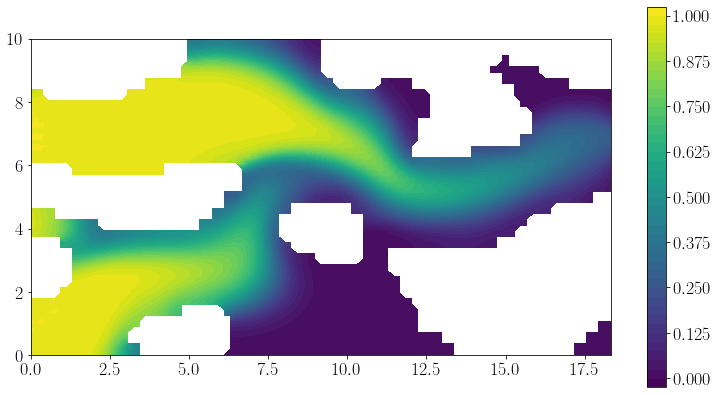

In [12]:
fig = plt.figure(figsize=(13,7))
cb = plot(solution[0])
fig.colorbar(cb)
plt.show()